In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from configparser import ConfigParser
from tqdm import tqdm
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
import numpy as np
import shutil
from openai import OpenAI
import os
import base64
import json
from io import BytesIO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report,precision_recall_fscore_support
import json

## Data

In [2]:
train_dir = "/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/train"
test_dir =  "/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test"

In [3]:
def get_data(root_directory):
    image_text_pairs = []
    # for label in os.listdir(root_directory):
    for label in ["lesion","normal","variation in normal","red lesion"]:
      label_dir = os.path.join(root_directory, label)
      if os.path.isdir(label_dir):
        # Iterate through each image in the label directory
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            # Check if the path is a file (to avoid subdirectories)
            if os.path.isfile(image_path):
                # Add the image path and label to the list
                if label != 'normal':
                    image_text_pairs.append((image_path, 'lesion'))
                    continue
                image_text_pairs.append((image_path, label))
    return image_text_pairs

In [4]:
test_df = pd.DataFrame(get_data(test_dir), columns=['image path','label'])
test_df

,image path,label
0,/content/drive/MyDrive/Binary_classification_u...,lesion
1,/content/drive/MyDrive/Binary_classification_u...,lesion
2,/content/drive/MyDrive/Binary_classification_u...,lesion
3,/content/drive/MyDrive/Binary_classification_u...,lesion
4,/content/drive/MyDrive/Binary_classification_u...,lesion
...,...,...
309,/content/drive/MyDrive/Binary_classification_u...,lesion
310,/content/drive/MyDrive/Binary_classification_u...,lesion
311,/content/drive/MyDrive/Binary_classification_u...,lesion
312,/content/drive/MyDrive/Binary_classification_u...,lesion


In [5]:
train_df = pd.DataFrame(get_data(train_dir), columns=['image path','label'])
train_df

,image path,label
0,/content/drive/MyDrive/Binary_classification_u...,lesion
1,/content/drive/MyDrive/Binary_classification_u...,lesion
2,/content/drive/MyDrive/Binary_classification_u...,lesion
3,/content/drive/MyDrive/Binary_classification_u...,lesion
4,/content/drive/MyDrive/Binary_classification_u...,lesion
...,...,...
739,/content/drive/MyDrive/Binary_classification_u...,lesion
740,/content/drive/MyDrive/Binary_classification_u...,lesion
741,/content/drive/MyDrive/Binary_classification_u...,lesion
742,/content/drive/MyDrive/Binary_classification_u...,lesion


# Data Processor

In [6]:
def to_base64(path):
    with open(path, 'rb') as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode('utf-8')
    return image_base64

class Processor:
    def __init__(self, lesion_image_list,max_size, normal_image_list,test_image_path):
        self.lesion_image_list = lesion_image_list
        self.normal_image_list = normal_image_list
        self.max_size = max_size
        self.test_image = test_image_path
        self.messages = None

    def get_image_data(self, img_path):
        return self.resize_and_convert_to_base64(img_path)

    def resize_and_convert_to_base64(self, image_path):
        size = self.max_size
        # Open the image file
        with Image.open(image_path) as img:
            # Check the size of the image
            width, height = img.size

            # Resize if either dimension is greater than 800 pixels
            if width > size or height > size:
                # Determine the new size while maintaining the aspect ratio
                if width > height:
                    new_width = size
                    new_height = int((size / width) * height)
                else:
                    new_height = size
                    new_width = int((size / height) * width)

                # Resize the image
                img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

            # Convert the image to base64
            buffered = BytesIO()
            img.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

            return img_base64

    def get_content(self):
        content_list = [{
            "type": "text",
            "text": """Here are some images and their respective classes. Please act as an image classifier and classify the last image as either "abnormal" or "normal" in the given format.
                       Respond only with either "abnormal" or "normal".
                       Do not write any explanations, comments, or plain text."""
        }]
        for img_path in self.lesion_image_list:
            content_list.append(
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{self.get_image_data(img_path)}"
                    }
                }
            )
            content_list.append(
                {"type": "text", "text": "abnormal"}
            )
        for img_num in self.normal_image_list:
            content_list.append(
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{self.get_image_data(img_path)}"
                    }
                }
            )
            content_list.append(
                {"type": "text", "text": "normal"}
            )


        return content_list

    def get_message(self):
        self.messages = [
            {"role": "user", "content": self.get_content()},
            {"role": "user", "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{self.get_image_data(self.test_image)}"
                    }
                }]
             }
        ]

## Setting up API

In [7]:
client = OpenAI(api_key = "sk-5MnwpVvFZ_HWVNnF4hxAznHFqSTyu2FOmOl4FiXrXnT3BlbkFJ0v7MT3OHej4IkO-4Gkml1fWiqmLcxBWvWItFtkR4oA")

def predict(lesion_image_list, max_size, normal_image_list, test_image_path):
    image_processor = Processor(lesion_image_list=lesion_image_list,
                                max_size=max_size,
                                normal_image_list=normal_image_list,
                                test_image_path = test_image_path)

    image_processor.get_message()
    messages = image_processor.messages

    response = client.chat.completions.create(
        model='gpt-4o-2024-11-20',
        messages=messages,
        temperature=0.0,
        max_tokens=200
    )

    return response.choices[0].message.content

## Prediction

In [8]:
max_size = 200
num_examples = 5

results = {}

num_runs = 5

for run in range(1,num_runs):
  print(f"Run {run+1} of {num_runs}")
  results[f"Run{run+1}"] = {}
  for idx in tqdm(test_df.index):
  # for idx in tqdm(range(2)):

      lesion_img_list = train_df[train_df["label"] == "lesion"].sample(n=num_examples)['image path']
      normal_img_list = train_df[train_df["label"] == "normal"].sample(n=num_examples)['image path']

      query_image_path = test_df["image path"][idx]

      expectation = test_df["label"][idx]
      if expectation == "lesion":
          expectation = "abnormal"
      test_image_name = query_image_path[94:]
      prediction = predict(lesion_image_list=lesion_img_list,
                            max_size=max_size,
                            normal_image_list=normal_img_list,
                          test_image_path = query_image_path
                          )

      results[f"Run{run+1}"][test_image_name] = {
          "query": query_image_path,
          "expectation": expectation,
          "prediction": prediction
      }
  # Save a checkpoint after each run with a descriptive filename
  checkpoint_path = f"/content/drive/MyDrive/Binary_classification_using_LLMs/Few Shot Learning/Results/Result_after_run_{run + 1}(final data).json"
  with open(checkpoint_path, "w") as outfile:
      json.dump(results, outfile)
  print(f"Checkpoint saved. Data available up to Run {run + 1}")

Run 2 of 5


100%|██████████| 314/314 [30:29<00:00,  5.83s/it]


Checkpoint saved. Data available up to Run 2
Run 3 of 5


100%|██████████| 314/314 [26:04<00:00,  4.98s/it]


Checkpoint saved. Data available up to Run 3
Run 4 of 5


100%|██████████| 314/314 [29:20<00:00,  5.61s/it]


Checkpoint saved. Data available up to Run 4
Run 5 of 5


100%|██████████| 314/314 [24:23<00:00,  4.66s/it]


Checkpoint saved. Data available up to Run 5


## Results

In [11]:
with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/Few Shot Learning/Results/Result_after_run_{1}(final data).json", 'r') as file:
    results1 = json.load(file)

with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/Few Shot Learning/Results/Result_after_run_{5}(final data).json", 'r') as file:
    results = json.load(file)

In [13]:
results.update(results1)

In [14]:
results.keys()

dict_keys(['Run2', 'Run3', 'Run4', 'Run5', 'Run1'])

Processing images for Run1: 100%|██████████| 314/314 [00:00<00:00, 497924.94it/s]


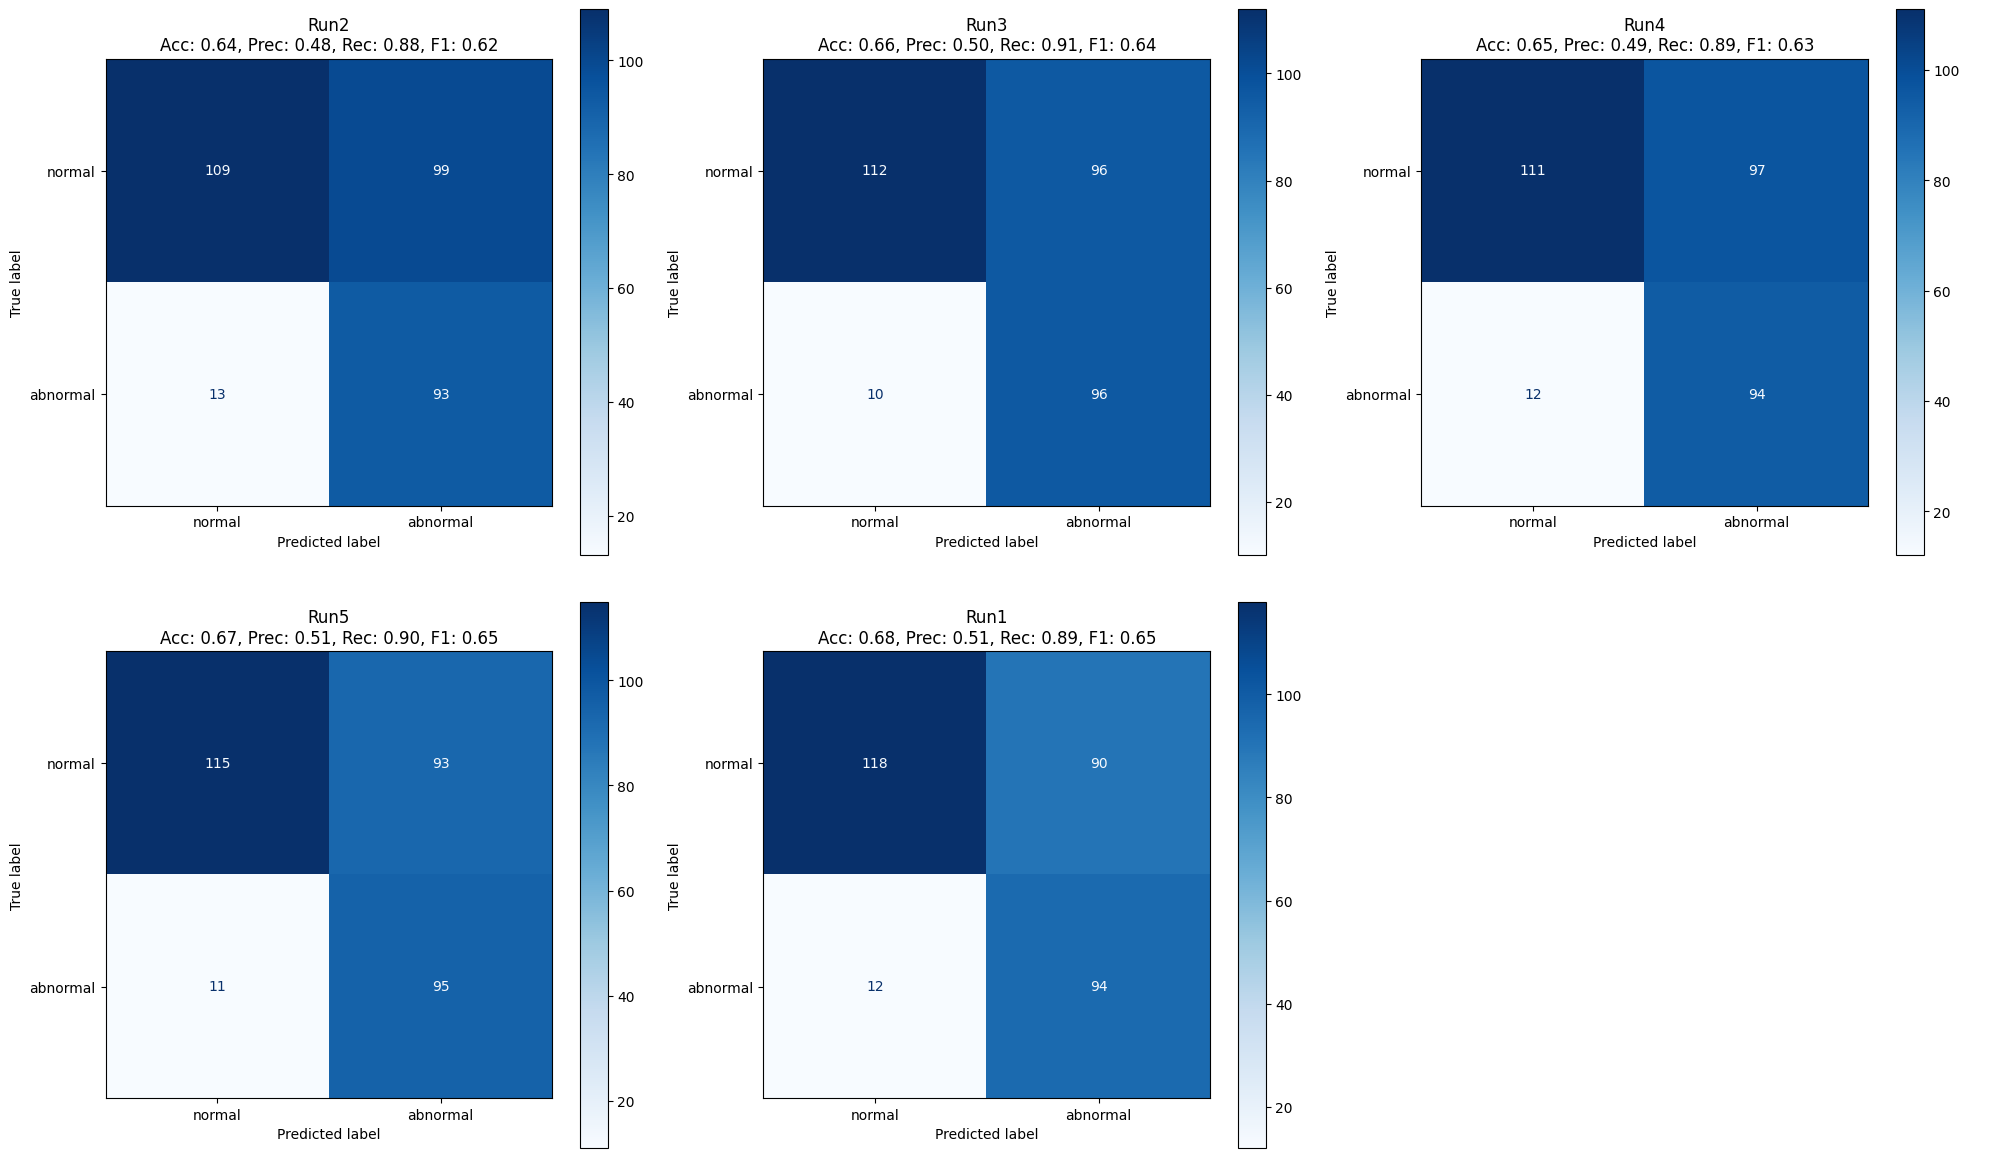

In [15]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Define class mappings
class_mapping = {"normal": 0, "abnormal": 1}

# Prepare a figure for subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # 2x3 grid
axes = axes.ravel()  # Flatten the axes array for easy indexing

metrics = {}

# Process results for each run
for idx, (run_name, run_data) in enumerate(results.items()):
    # Initialize lists for actual and prediction values
    actual = []
    prediction = []
    unknown_classes = []
    metrics[run_name] = {}

    # Process each image in the run
    for img, data in tqdm(run_data.items(), desc=f"Processing images for {run_name}"):
        actual_class = data["expectation"]
        pred_class = data["prediction"]

        if pred_class not in class_mapping:
            unknown_classes.append((img, actual_class, pred_class))
            print(f"Unknown class in prediction: {pred_class}")
            continue
        else:
            pred_label = class_mapping[pred_class]
            prediction.append(pred_label)
            actual_label = class_mapping[actual_class]
            actual.append(actual_label)

    # Compute metrics
    accuracy = accuracy_score(actual, prediction)
    precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"])
    recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"])
    f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"])

    metrics[run_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "unknown_classes": unknown_classes
    }

    # Compute confusion matrix with specified labels
    matrix = confusion_matrix(actual, prediction, labels=list(class_mapping.values()))

    # Plot confusion matrix in a subplot
    ax = axes[idx]  # Use the flattened axes array
    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(class_mapping.keys()))
    cm_display.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(
        f"{run_name}\n"
        f"Acc: {accuracy:.2f}, Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}"
    )

# Hide the last subplot (6th subplot) if there are only 5 runs
if len(results) < 6:
    axes[-1].axis('off')  # Hide the last subplot

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define class mappings
class_mapping = {"normal": 0, "abnormal": 1}

# Example results dictionary (replace with your actual data)
expert_list = ['resnet50_pretrained_cosine', 'resnet50_pretrained_one', 'resnet50_pretrained_euclidean', "resnet50_pretrained_inf","resnet50_pretrained_-inf", "Mixture of Experts(5_experts)",'resnet50_pretrained_random']

all_expert_5_runs_results = {
    "few shot": [results["Run1"], results["Run2"], results["Run3"], results["Run4"], results["Run5"]],
}

# Function to extract the "output" value from the prediction string
def extract_output(prediction):
    if isinstance(prediction, str):
        return prediction.strip().lower()
    elif isinstance(prediction, dict):
        return prediction.get("output", "").strip().lower()
    else:
        return ""

# Function to create a DataFrame with metrics for each expert and run
def create_metrics_dataframe(all_expert_5_runs_results, class_mapping):
    # Initialize a dictionary to store metrics for each expert
    expert_metrics = {}

    for expert_name, expert_runs in all_expert_5_runs_results.items():
        # Initialize a dictionary to store metrics for each run of the current expert
        run_metrics = {}

        for run_idx, run_data in enumerate(expert_runs):
            actual = []
            prediction = []
            unknown_classes = []

            for img, data in run_data.items():
                actual_class = data["expectation"].lower()
                pred_class = extract_output(data["prediction"])

                if pred_class not in class_mapping:
                    unknown_classes.append((img, actual_class, pred_class))
                    continue
                else:
                    pred_label = class_mapping[pred_class]
                    prediction.append(pred_label)
                    actual_label = class_mapping[actual_class]
                    actual.append(actual_label)

            # Compute metrics
            accuracy = accuracy_score(actual, prediction) * 100
            precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
            recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
            f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
            specificity = recall_score(actual, prediction, average='binary', pos_label=class_mapping["normal"], zero_division=0) * 100

            # Store metrics for the current run
            # run_metrics[f"accuracy_run{run_idx + 1}"] = accuracy
            # run_metrics[f"precision_run{run_idx + 1}"] = precision
            # run_metrics[f"recall_run{run_idx + 1}"] = recall
            # run_metrics[f"f1_run{run_idx + 1}"] = f1
            # run_metrics[f"specificity_run{run_idx + 1}"] = specificity

            run_metrics[f"accuracy_run{run_idx + 1}"] = round(accuracy, 4)
            run_metrics[f"precision_run{run_idx + 1}"] = round(precision, 4)
            run_metrics[f"recall_run{run_idx + 1}"] = round(recall, 4)
            run_metrics[f"f1_run{run_idx + 1}"] = round(f1, 4)
            run_metrics[f"specificity_run{run_idx + 1}"] = round(specificity, 4)

        # Store metrics for the current expert
        expert_metrics[expert_name] = run_metrics

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame.from_dict(expert_metrics, orient='index')
    column_order = ['accuracy_run1', 'accuracy_run2', 'accuracy_run3', 'accuracy_run4', 'accuracy_run5',
                'precision_run1', 'precision_run2', 'precision_run3', 'precision_run4', 'precision_run5',
                'recall_run1', 'recall_run2', 'recall_run3', 'recall_run4', 'recall_run5',
                'specificity_run1', 'specificity_run2', 'specificity_run3', 'specificity_run4', 'specificity_run5',
                'f1_run1', 'f1_run2', 'f1_run3', 'f1_run4', 'f1_run5']
    metrics_df = metrics_df.loc[:, column_order]
    return metrics_df

# Create the DataFrame
metrics_df = create_metrics_dataframe(all_expert_5_runs_results, class_mapping)
print(metrics_df)

          accuracy_run1  accuracy_run2  accuracy_run3  accuracy_run4  \
few shot        67.5159        64.3312         66.242        65.2866   

          accuracy_run5  precision_run1  precision_run2  precision_run3  \
few shot         66.879          51.087         48.4375            50.0   

          precision_run4  precision_run5  ...  specificity_run1  \
few shot         49.2147         50.5319  ...           56.7308   

          specificity_run2  specificity_run3  specificity_run4  \
few shot           52.4038           53.8462           53.3654   

          specificity_run5  f1_run1  f1_run2  f1_run3  f1_run4  f1_run5  
few shot           55.2885  64.8276  62.4161  64.4295  63.2997  64.6259  

[1 rows x 25 columns]


In [18]:
metrics_df.to_excel("/content/drive/MyDrive/Binary_classification_using_LLMs/Few Shot Learning/Results/all_runs.xlsx")

In [ ]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import pandas as pd
import xlsxwriter

# Define class mappings
class_mapping = {"normal": 1,"lesion": 0}

# Prepare an Excel writer
output_file = "/content/drive/MyDrive/Binary_classification_using_LLMs/Few Shot Learning/Results/classification_results_with_paths.xlsx"
writer = pd.ExcelWriter(output_file, engine="xlsxwriter")

# Process results for each run
for run_name, run_data in results.items():
    print(f"Processing {run_name}...")

    # Initialize lists for actual, prediction, and misclassification
    actual = []
    prediction = []
    false_positives = []
    false_negatives = []
    unknown_classes = []

    # Process each image
    for img_path, data in tqdm(run_data.items(), desc=f"Processing images for {run_name}"):
        actual_class = data["expectation"]
        pred_class = data["prediction"]
        query_image_path = data["query_image_path"]

        if pred_class not in class_mapping or actual_class not in class_mapping:
            unknown_classes.append((query_image_path, actual_class, pred_class))
            continue

        actual_label = class_mapping[actual_class]
        pred_label = class_mapping[pred_class]
        actual.append(actual_label)
        prediction.append(pred_label)

        # Classify misclassifications
        if actual_label != pred_label:
            if pred_label == class_mapping["lesion"]:
                false_positives.append(query_image_path)  # Predicted lesion, but actual is normal
            else:
                false_negatives.append(query_image_path)  # Predicted normal, but actual is lesion

    # Save false positives and false negatives to a DataFrame
    misclass_df = pd.DataFrame({
        "False Positives (Image Path)": false_positives + [""] * (len(false_negatives) - len(false_positives)),
        "False Negatives (Image Path)": false_negatives + [""] * (len(false_positives) - len(false_negatives))
    })
    misclass_df.to_excel(writer, sheet_name=f"{run_name}_Misclassifications", index=False)

    # Save unknown classes to a DataFrame
    unknown_df = pd.DataFrame(unknown_classes, columns=["Image Path", "Expectation", "Prediction"])
    if not unknown_df.empty:
        unknown_df.to_excel(writer, sheet_name=f"{run_name}_Unknown", index=False)

# Save the Excel file
writer.close()
print(f"Results saved to {output_file}.")

Processing Run1...


Processing images for Run1: 100%|██████████| 311/311 [00:00<00:00, 364263.77it/s]

Results saved to /content/drive/MyDrive/Binary_classification_using_LLMs/Few Shot Learning/Results/classification_results_with_paths.xlsx.
